# Memory Management

## Objectives

### Pre-Reading

Either watch [DDCArv Ch8 - Part 1: Memory System Introduction](https://www.youtube.com/watch?v=hOxto8az7pQ)
or read [*DDCA* 8.1 Memory Systems Introduction](https://learning.oreilly.com/library/view/digital-design-and/9780128009116/xhtml/chp008.xhtml#st0010).
(This link is to the ARM version, but if you have a copy of the RISC-V version, that will work too!)

## Cache Demo

To demonstrate the importance of a cache on performance, we will perform edge detection via 2D-convolution on an image.

We will benchmark several image sizes and compare the convolution speed relative to the image size.

We expect to see a drastic increase in time when the image is larger than the cache, compared to when the entire image fits in the cache.

### Edge Detection

In [4]:
%pip install -q pillow

Note: you may need to restart the kernel to use updated packages.


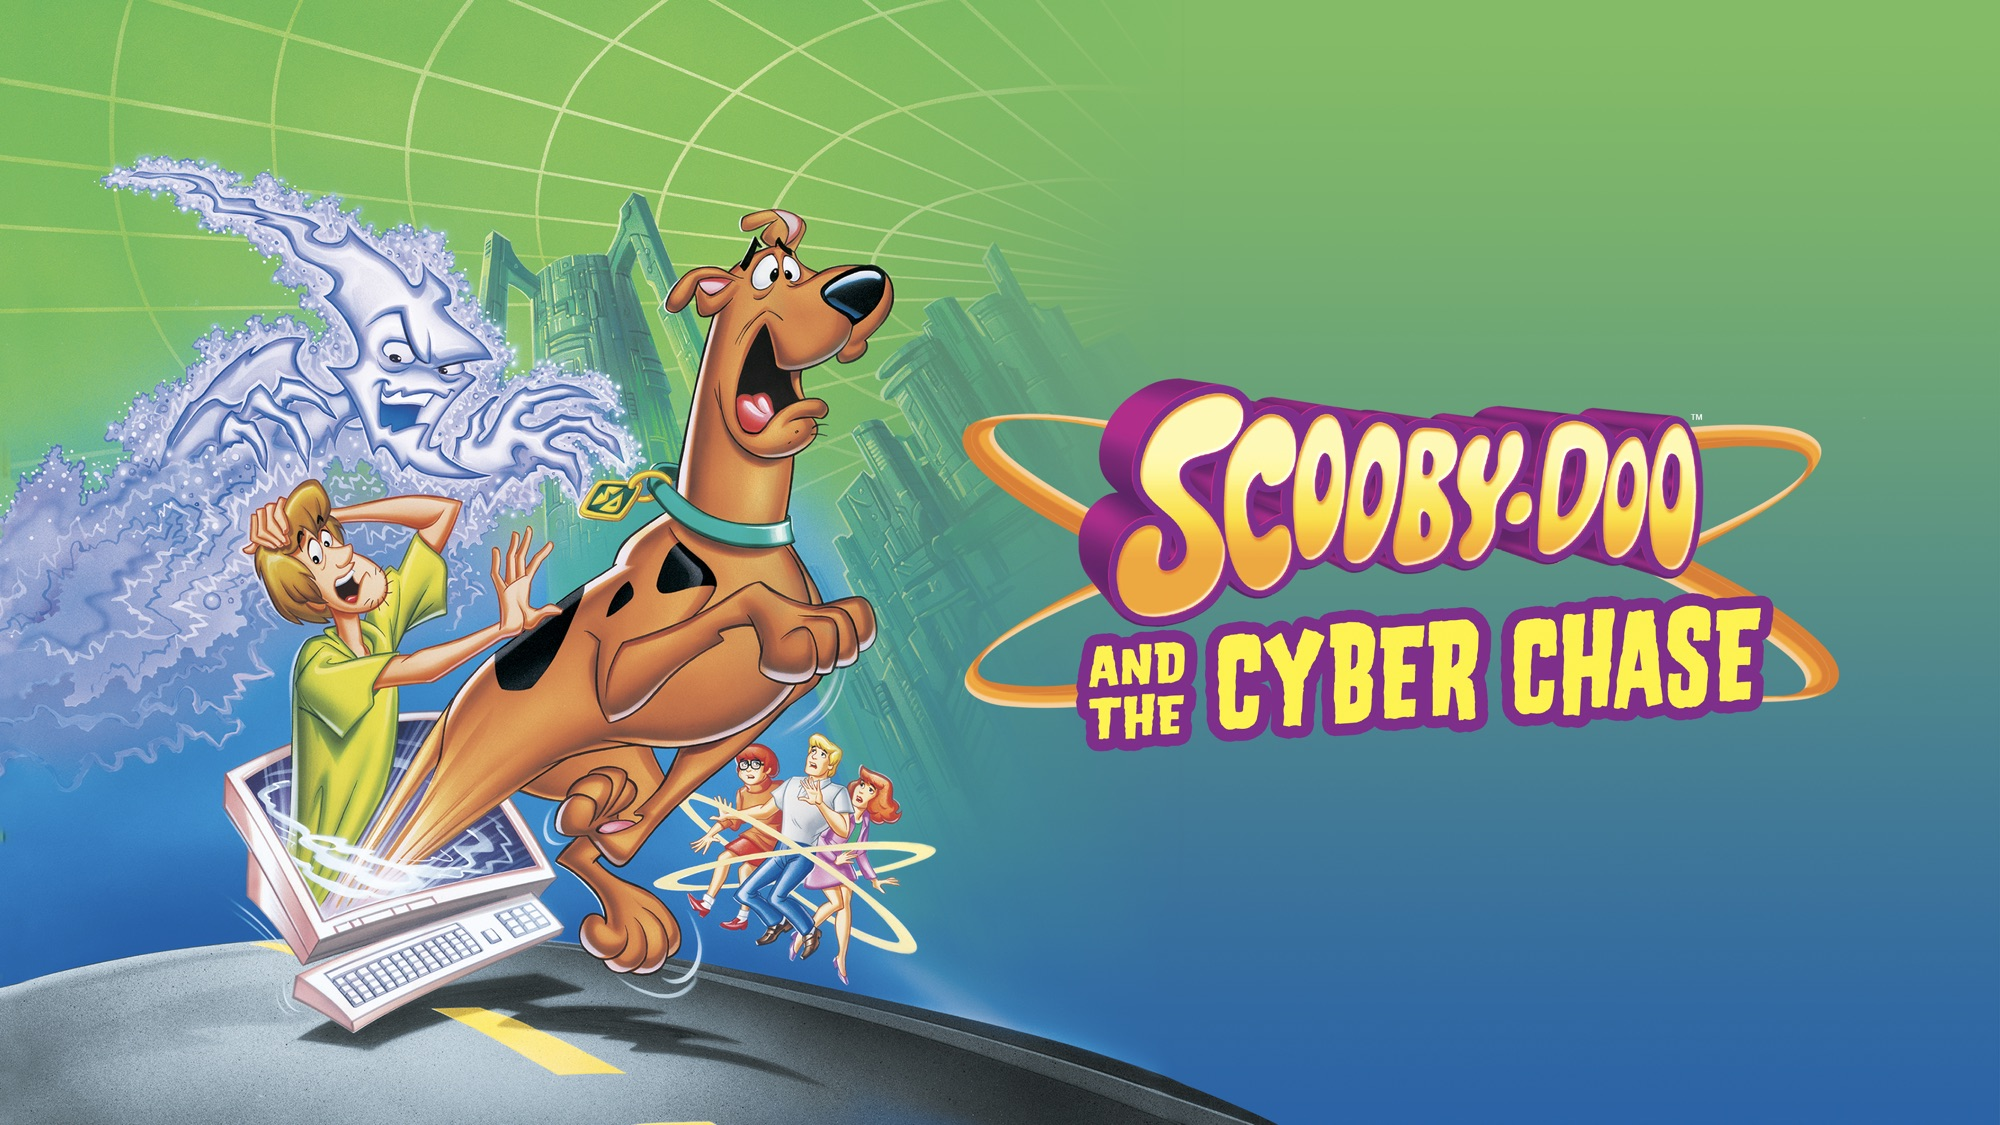

In [5]:
# Get an image from URL with Python built-in libraries and open with Pillow
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

url = "https://raw.githubusercontent.com/USAFA-ECE/ece386-book/864fdcddabe9217da3d00947c30fd33abf1af03c/book/data/scooby-cyber-chase.jpg"

# Make the HTTP request to get the image
bytes_from_url = BytesIO(urlopen(url).read())
# Convert the raw bytes to an image and convert to grayscale
base_img = Image.open(bytes_from_url)  # .convert("L")

# Display the image with IPython, small size
display(base_img)

We will run 2D-convolution on this image using Pillow's `ImageFilter.FIND_EDGES`.

This function slides a Laplacian Kernel across the image and detects edges.

$$
\begin{bmatrix}
-1 & -1 & -1\\
-1 &  8 & -1\\
-1 & -1 & -1
\end{bmatrix}
$$

See [GeeksForGeeks - Edge Detection using Pillow](https://www.geeksforgeeks.org/python-edge-detection-using-pillow/)



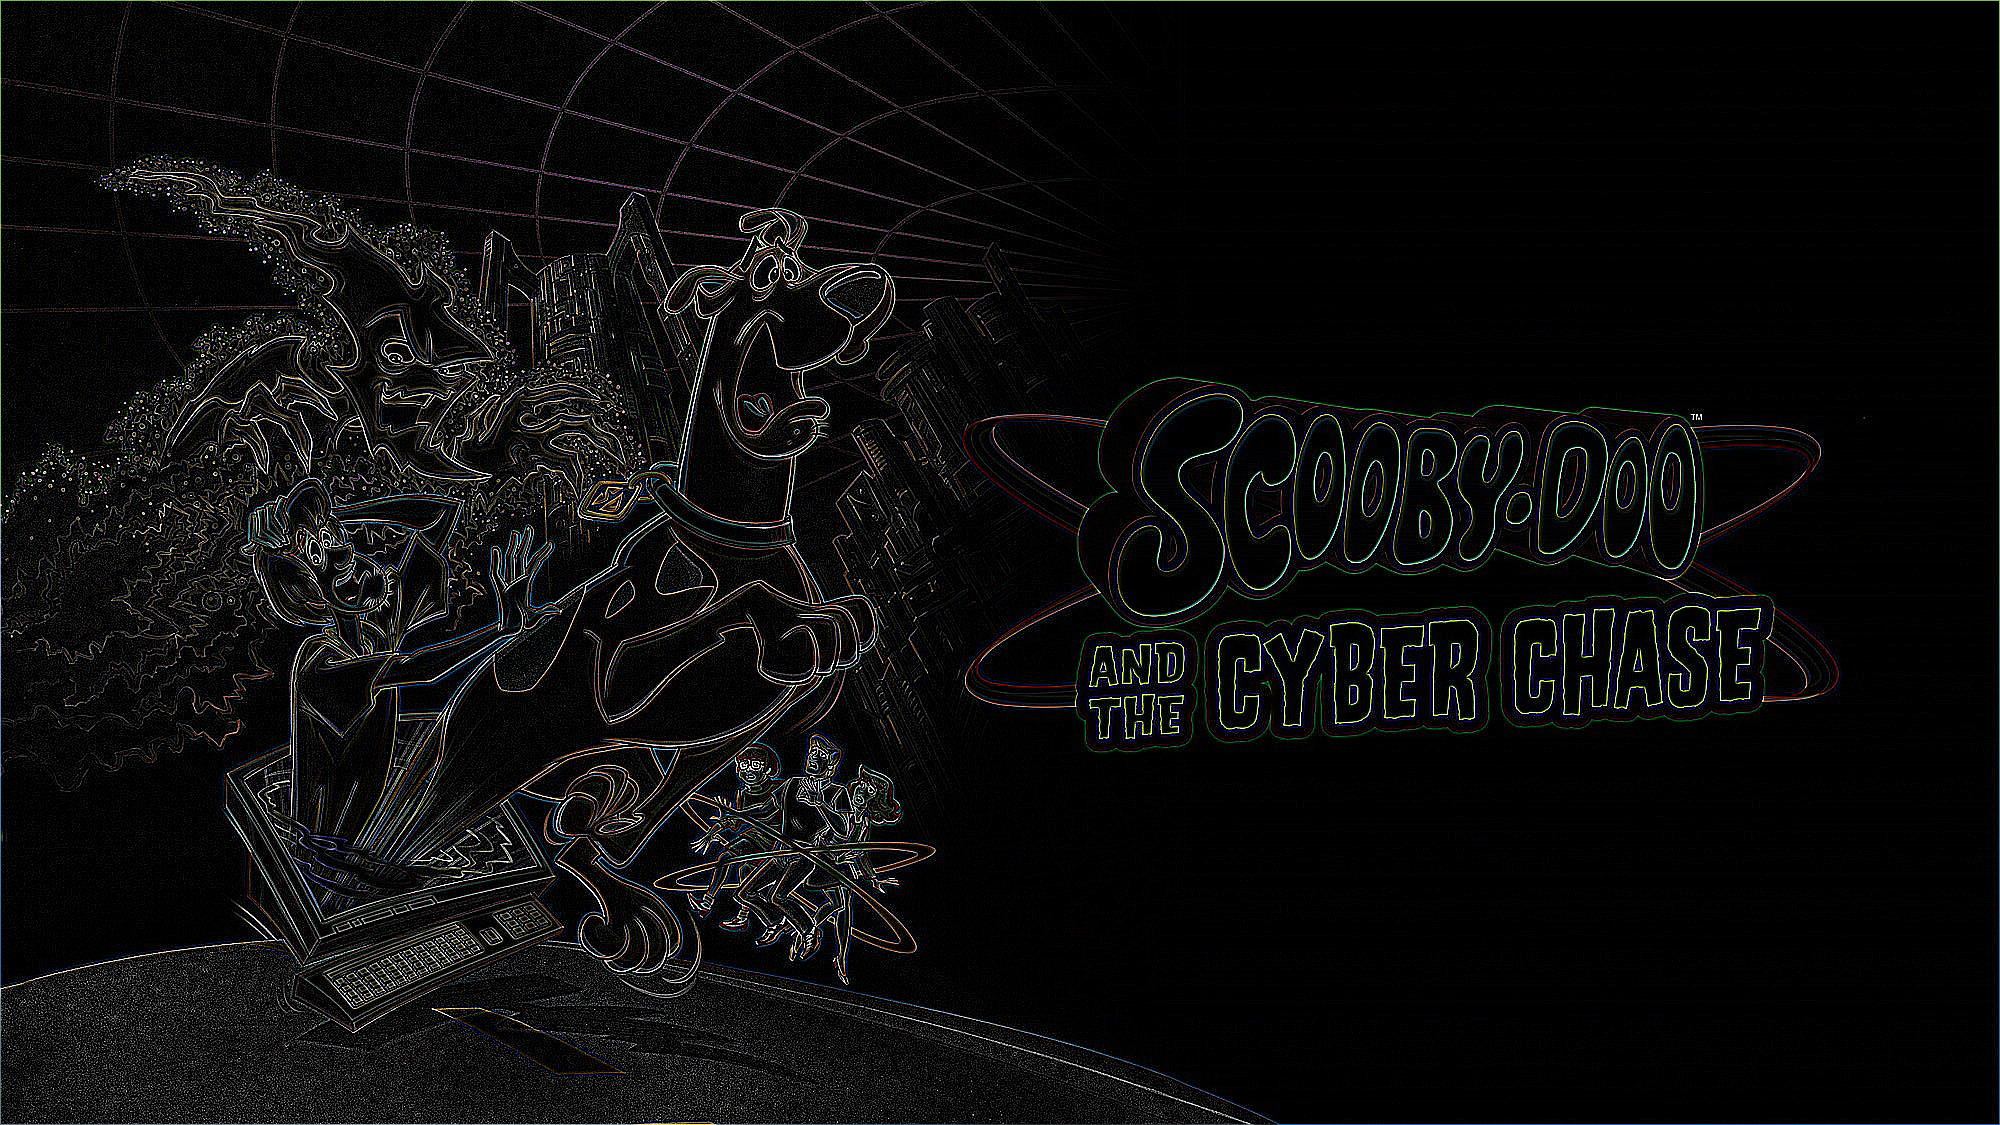

In [6]:
# Perform edge detection on the image
from PIL import ImageFilter

edges = base_img.filter(ImageFilter.FIND_EDGES)
display(edges)

### Benchmark

We will simply rescale are image multiple times, perform edge detection, and compare the results!

First let's define a function to scale the image and find the size in memory.

In [8]:
import sys


def rescale_image(image: Image.Image, scale_factor: float) -> tuple[Image.Image, int]:
    """Resizes image by a scale factor and returns its byte size in KB."""
    new_size = (int(image.width * scale_factor), int(image.height * scale_factor))
    resized_image = image.resize(
        new_size, Image.BICUBIC
    )  # BICUBIC balances speed and quality
    # Calculate the image size
    bytes_per_pixel = len(resized_image.getbands())  # RGB = 3, RGBA = 4, L = 1
    memory_size = (
        new_size[0] * new_size[1] * bytes_per_pixel
    )  # Pixel count * bytes per pixel
    memory_size += sys.getsizeof(resized_image)  # Add the size of the Python overhead
    return resized_image, memory_size / 1024

In [9]:
_, base_size = rescale_image(base_img, 1.0)
print(f"Base image takes {base_size:.2f} KB in memory")

Base image takes 6591.84 KB in memory


Now for our actual benchmark.

In [25]:
import timeit

scale_factors = [0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

sizes = []
times = []

# Iterate through each scale
for scale in scale_factors:
    resized, size = rescale_image(base_img, scale)
    _ = resized.filter(ImageFilter.FIND_EDGES)  # Warm-up run

    # Measure time using timeit
    time_taken = (
        timeit.timeit(lambda: resized.filter(ImageFilter.FIND_EDGES), number=10) * 1e2
    )  # Convert to ms and divide by 10

    sizes.append(size)
    times.append(time_taken)

    print(
        f"Edge detection at scale {scale:.2f} ({size:.2f}KB) took {time_taken:.2f} ms"
    )

Edge detection at scale 0.75 (3704.64KB) took 44.51 ms
Edge detection at scale 0.70 (3227.98KB) took 38.83 ms
Edge detection at scale 0.65 (2784.13KB) took 34.17 ms
Edge detection at scale 0.60 (2373.09KB) took 27.61 ms
Edge detection at scale 0.55 (1991.65KB) took 22.62 ms
Edge detection at scale 0.50 (1646.53KB) took 20.37 ms
Edge detection at scale 0.45 (1334.23KB) took 15.73 ms
Edge detection at scale 0.40 (1054.73KB) took 13.64 ms
Edge detection at scale 0.35 (806.00KB) took 11.35 ms
Edge detection at scale 0.30 (592.43KB) took 8.32 ms
Edge detection at scale 0.25 (411.67KB) took 5.98 ms
Edge detection at scale 0.20 (263.72KB) took 3.30 ms


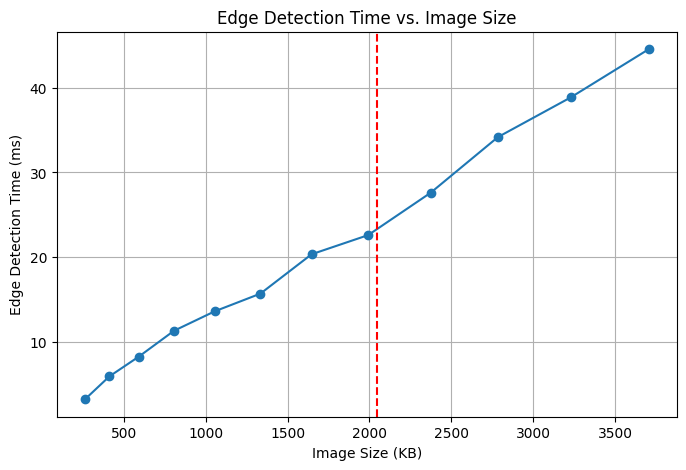

In [26]:
import matplotlib.pyplot as plt

# Input the cache size on your device
# For Raspberry Pi 5, the L3 cache is 2MB
cache_size = 2 * 1024  # Convert to KB

# Plot size vs. processing time
plt.figure(figsize=(8, 5))
plt.plot(sizes, times, marker="o", linestyle="-")
plt.axvline(
    cache_size, color="red", linestyle="--", label="L2 Cache Size"
)  # line at cache size
plt.xlabel("Image Size (KB)")
plt.ylabel("Edge Detection Time (ms)")
plt.title("Edge Detection Time vs. Image Size")
plt.grid(True)
plt.show()